In [1]:
import torch

import triton
import triton.language as tl
import matplotlib
import pandas as pd
import numpy as np


In [2]:
# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)

@triton.jit
def d_leacky_relu_inv_backward(x):
    return tl.where(x >= 0, 1.0, 100.0)



In [3]:
# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=[
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 64}, num_stages=3, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 64}, num_stages=3, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 128}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 128}, num_stages=2, num_warps=4),
    ],
    key=['B', 'D', 'E'],
)
@triton.jit
def mlp_wide_kernel_fwd(
    # Pointers to matrices
    x_ptr, w1_ptr, w2_ptr, o_ptr,
    # Matrix dimensions
    H, B, D: tl.constexpr, E,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    # Meta-parameters
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr,
):
    """Kernel for computing the mlp
    Z = X @ W1, H = f(Z), O = H @ W2.
    - X has shape (B, D)
    - W1 has shape (D, E)
    - W2 has shape (E, D)
    - O has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    pid = tl.program_id(axis=0)
    batch_groups = tl.cdiv(B, BLOCK_SIZE_B)
    pid_b = pid % batch_groups
    pid_h = pid // batch_groups
    # tl.device_print('pid_H', pid_h)
    # tl.device_print('pid_B', pid_b)
    # pid_d = tl.program_id(axis=1)
    TARGET_TYPE = x_ptr.type.element_ty
    x_ptrs = tl.make_block_ptr(
        base=x_ptr,
        shape=(B * H, D),
        strides=(stride_xb, stride_xd),
        offsets=(pid_h * B + pid_b * BLOCK_SIZE_B, 0),
        block_shape=(BLOCK_SIZE_B, D),
        order=(1, 0),
    )
    w1_ptrs = tl.make_block_ptr(
        base=w1_ptr,
        shape=(D * H, E),
        strides=(stride_w1d, stride_w1e),
        offsets=(pid_h * D, 0),
        block_shape=(D, BLOCK_SIZE_E),
        order=(1, 0),
    )
    w2_ptrs = tl.make_block_ptr(
        base=w2_ptr,
        shape=(E * H, D),
        strides=(stride_w2e, stride_w2d),
        offsets=(pid_h * E, 0),
        block_shape=(BLOCK_SIZE_E, D),
        order=(1, 0),
    )
    o_ptrs = tl.make_block_ptr(
        base=o_ptr,
        shape=(B * H, D),
        strides=(stride_ob, stride_od),
        offsets=(pid_h * B + pid_b * BLOCK_SIZE_B, 0),
        block_shape=(BLOCK_SIZE_B, D),
        order=(1, 0),
    )
    x = tl.load(x_ptrs) # BLOCK_SIZE_B, D
    o = tl.zeros((BLOCK_SIZE_B, D), dtype=tl.float32)
    for e in range(0, tl.cdiv(E, BLOCK_SIZE_E)):
        # z = tl.zeros((BLOCK_SIZE_B, BLOCK_SIZE_E), dtype=tl.float32)
        # loop over D
        w1 = tl.load(w1_ptrs)       # D, BLOCK_SIZE_E
        w2 = tl.load(w2_ptrs)       # BLOCK_SIZE_E, D
        z = tl.dot(x, w1, out_dtype=tl.float32)        # BLOCK_SIZE_B, BLOCK_SIZE_E
        # activation
        if ACTIVATION == "leaky_relu":
            z = leaky_relu(z).to(TARGET_TYPE)
        else:
            z = z.to(TARGET_TYPE)
        # accumulate with o
        o = tl.dot(z, w2, o, out_dtype=tl.float32)        # BLOCK_SIZE_B, D
        # advance w1 and w2
        w1_ptrs = tl.advance(w1_ptrs, (0, BLOCK_SIZE_E))
        w2_ptrs = tl.advance(w2_ptrs, (BLOCK_SIZE_E, 0))

    o = o.to(TARGET_TYPE)
    # tl.static_print('o_ptrs', o_ptrs, o)
    tl.store(o_ptrs, o)


In [4]:
def mlp_wide_triton_fwd(x, w1, w2, activation=""):
    # Check constraints.
    assert x.shape[0] == w1.shape[0], "Incompatible dimensions"
    assert x.shape[0] == w2.shape[0], "Incompatible dimensions"
    assert x.shape[2] == w1.shape[1], "Incompatible dimensions"
    assert w1.shape[2] == w2.shape[1], "Incompatible dimensions"
    assert x.shape[2] == w2.shape[2], "Incompatible dimensions"

    H, B, D = x.shape
    E = w1.shape[-1]

    # print(H, B, D, E)
    # print(x.shape, w1.shape, w2.shape)

    x = x.view(H * B, D)
    w1 = w1.view(D * H, E)
    w2 = w2.view(E * H, D)

    assert x.is_contiguous(), "Matrix X must be contiguous"
    assert w1.is_contiguous(), "Matrix W1 must be contiguous"
    assert w2.is_contiguous(), "Matrix W2 must be contiguous"

    # Allocates output.
    o = torch.zeros_like(x)
    #print(x.shape, w1.shape, w2.shape, o.shape)
    # print(o.shape)

    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(B, META['BLOCK_SIZE_B']) * H,
    )
    mlp_wide_kernel_fwd[grid](
        x, w1, w2, o,
        H, B, D, E,
        x.stride(0), x.stride(1),
        w1.stride(0), w1.stride(1),
        w2.stride(0), w2.stride(1),
        o.stride(0), o.stride(1),
        ACTIVATION=activation
    )

    # print(o.shape)
    return o.reshape(H, B, D)


In [5]:
def mlp_torch_fwd(x, w1, w2, activation=""):
    z = torch.bmm(x, w1)
    if activation == "leaky_relu":
        z = torch.nn.functional.leaky_relu(z)
    o = torch.bmm(z, w2)
    return o



In [6]:
def unit_test_fwd():
    # torch.manual_seed(115)
    dtype = torch.bfloat16
    B = 1024
    D = 16
    E = 768
    H = 12
    x = torch.randn((H, B, D), device='cuda', dtype=dtype) / np.sqrt(D)
    w1 = torch.randn((H, D, E), device='cuda', dtype=dtype) / np.sqrt(E)
    w2 = torch.randn((H, E, D), device='cuda', dtype=dtype) / np.sqrt(D)
    triton_output = mlp_wide_triton_fwd(x, w1, w2, activation="leaky_relu")
    torch_output = mlp_torch_fwd(x, w1, w2, activation="leaky_relu")
    print(f"triton_output={triton_output.shape, triton_output}")
    print(f"torch_output={torch_output.shape, torch_output}")
    if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=1e-2):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

    diff = np.abs(triton_output.to(torch.float32).cpu().numpy() - torch_output.to(torch.float32).cpu().numpy())
    print("max diff:",np.max(diff))
    print("mean diff:",np.mean(diff))

unit_test_fwd()


triton_output=(torch.Size([12, 1024, 16]), tensor([[[ 4.6875e-02,  2.7930e-01,  1.7822e-02,  ..., -2.0874e-02,
           6.7871e-02, -5.8350e-02],
         [ 1.6211e-01, -1.6309e-01,  8.3008e-02,  ...,  9.1797e-02,
          -2.4902e-01,  3.3398e-01],
         [-2.2754e-01, -1.9238e-01, -7.6660e-02,  ..., -4.8584e-02,
           2.6758e-01,  4.4189e-02],
         ...,
         [ 8.9844e-02,  1.0449e-01, -4.8584e-02,  ..., -8.4473e-02,
          -3.4766e-01,  3.8086e-01],
         [ 2.1484e-01, -1.6211e-01, -1.4551e-01,  ...,  4.1504e-02,
          -2.2070e-01,  1.9727e-01],
         [-6.6895e-02,  1.3965e-01, -2.4902e-01,  ...,  6.8848e-02,
           8.0078e-02, -3.3691e-02]],

        [[-7.6660e-02,  6.5430e-02, -8.3008e-02,  ...,  4.1260e-02,
           1.4551e-01,  2.4512e-01],
         [-1.2793e-01,  1.2354e-01,  1.5918e-01,  ...,  3.0664e-01,
           3.2812e-01,  1.2793e-01],
         [-3.2812e-01, -1.1035e-01,  2.0801e-01,  ...,  2.0508e-01,
           1.7188e-01,  1.2598e-0

In [7]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['E'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            # 2 ** i for i in range(5, 12)
            128 * i for i in range(2, 16)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch-16', 'triton-16', 'torch-64', 'triton-64', 'torch-128', 'triton-128'],
        # Label name for the lines
        line_names=["Torch-16", "Triton-16", "Torch-64", "Triton-64", "Torch-128", "Triton-128"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark_fwd(E, provider):
    dtype = torch.bfloat16
    D = int(provider[provider.find('-') + 1:])
    HEAD = 768 // D
    L = 1024
    S = 4
    B = L * S
    x = torch.randn((HEAD, B, D), device='cuda', dtype=dtype)
    w1 = torch.randn((HEAD, D, E), device='cuda', dtype=dtype)
    w2 = torch.randn((HEAD, E, D), device='cuda', dtype=dtype)
    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('torch'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_torch_fwd(x, w1, w2, activation="leaky_relu"), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_wide_triton_fwd(x, w1, w2, activation="leaky_relu"), quantiles=quantiles)
    perf = lambda ms: 4 * B * D * E * HEAD * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


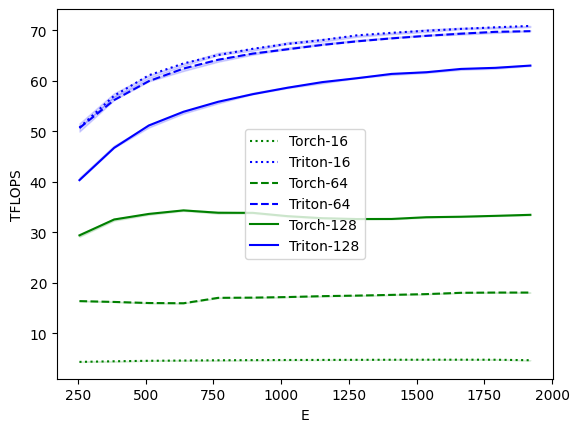

mlp-performance:
         E  Torch-16  Triton-16   Torch-64  Triton-64  Torch-128  Triton-128
0    256.0  4.356964  50.737549  16.383999  50.648196  29.399327   40.329848
1    384.0  4.481094  57.033028  16.222061  56.173715  32.542014   46.718734
2    512.0  4.575188  61.082098  16.008794  59.918629  33.644150   51.150047
3    640.0  4.623351  63.421936  15.963098  62.415239  34.342009   53.865203
4    768.0  4.676503  65.084028  17.033668  64.157611  33.874358   55.841323
5    896.0  4.706248  66.325591  17.075632  65.371841  33.854285   57.343998
6   1024.0  4.734172  67.288300  17.189771  66.225851  33.200295   58.618895
7   1152.0  4.747075  68.056616  17.369051  67.088984  32.798845   59.729013
8   1280.0  4.766051  68.985262  17.476267  67.795860  32.632033   60.494769
9   1408.0  4.778885  69.483951  17.618639  68.385390  32.644346   61.352852
10  1536.0  4.790448  69.905069  17.772474  68.884557  32.989936   61.680941
11  1664.0  4.791945  70.265401  18.031068  69.312650  33.0

In [8]:
benchmark_fwd.run(show_plots=True, print_data=True)


In [9]:
@triton.autotune(
    configs=[
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 64}, num_stages=3, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 64}, num_stages=3, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 64, 'GROUP_SIZE_B': 1}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 128, 'GROUP_SIZE_B': 1}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 128}, num_stages=2, num_warps=4),
    ],
    key=['B', 'D', 'E'],
)
@triton.jit
def mlp_wide_kernel_bwd1(
    x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
    B, D: tl.constexpr, E,
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    stride_dxb, stride_dxd,
    stride_dw1d, stride_dw1e,
    stride_dw2e, stride_dw2d,
    stride_dob, stride_dod,
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr
):
    """Kernel for computing the mlp
    Z = X @ W1, H = f(Z), O = H @ W2
    - X has shape (B, D)
    - W1 has shape (D, E)
    - W2 has shape (E, D)
    - O has shape (B, D)
    - dX has shape (B, D)
    - dW1 has shape (D, E)
    - dW2 has shape (E, D)
    - dO has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    pid_e = tl.program_id(axis=0)
    # batch_groups = tl.cdiv(B, BLOCK_SIZE_B)
    # pid_b = pid % batch_groups
    # pid_h = pid // batch_groups
    # tl.device_print('pid_H', pid_h)
    # tl.device_print('pid_B', pid_b)
    # pid_d = tl.program_id(axis=1)
    TARGET_TYPE = x_ptr.type.element_ty

    offs_b = tl.arange(0, BLOCK_SIZE_B)
    offs_d = tl.arange(0, D)
    dx_ptrs = dx_ptr + (offs_b[:, None] * stride_dxb + offs_d[None, :] * stride_dxd)

    x_ptrs = tl.make_block_ptr(
        base=x_ptr,
        shape=(B, D),
        strides=(stride_xb, stride_xd),
        offsets=(0, 0),
        block_shape=(BLOCK_SIZE_B, D),
        order=(1, 0),
    )
    w1_ptrs = tl.make_block_ptr(
        base=w1_ptr,
        shape=(D, E),
        strides=(stride_w1d, stride_w1e),
        offsets=(0, pid_e * BLOCK_SIZE_E),
        block_shape=(D, BLOCK_SIZE_E),
        order=(1, 0),
    )
    dw1_ptrs = tl.make_block_ptr(
        base=dw1_ptr,
        shape=(D, E),
        strides=(stride_dw1d, stride_dw1e),
        offsets=(0, pid_e * BLOCK_SIZE_E),
        block_shape=(D, BLOCK_SIZE_E),
        order=(1, 0),
    )
    w2_ptrs = tl.make_block_ptr(
        base=w2_ptr,
        shape=(E, D),
        strides=(stride_w2e, stride_w2d),
        offsets=(pid_e * BLOCK_SIZE_E, 0),
        block_shape=(BLOCK_SIZE_E, D),
        order=(1, 0),
    )
    dw2_ptrs = tl.make_block_ptr(
        base=dw2_ptr,
        shape=(E, D),
        strides=(stride_dw2e, stride_dw2d),
        offsets=(pid_e * BLOCK_SIZE_E, 0),
        block_shape=(BLOCK_SIZE_E, D),
        order=(1, 0),
    )
    do_ptrs = tl.make_block_ptr(
        base=do_ptr,
        shape=(B, D),
        strides=(stride_dob, stride_dod),
        offsets=(0, 0),
        block_shape=(BLOCK_SIZE_B, D),
        order=(1, 0),
    )
    w1 = tl.load(w1_ptrs) # D, BLOCK_SIZE_E
    w2 = tl.load(w2_ptrs) # BLOCK_SIZE_E, D
    dw1 = tl.zeros((D, BLOCK_SIZE_E), dtype=tl.float32)  # D, BLOCK_SIZE_E
    dw2 = tl.zeros((BLOCK_SIZE_E, D), dtype=tl.float32)  # BLOCK_SIZE_E, D
    # dx = tl.zeros((BLOCK_SIZE_B, D), dtype=TARGET_TYPE)  # BLOCK_SIZE_B, D
    for b in range(0, tl.cdiv(B, BLOCK_SIZE_B)):
        x = tl.load(x_ptrs) # BLOCK_SIZE_B, D
        # dx = tl.load(dx_ptrs) # BLOCK_SIZE_B, D
        # o = tl.load(o_ptrs) # BLOCK_SIZE_B, D
        do = tl.load(do_ptrs) # BLOCK_SIZE_B, D

        z = tl.dot(x, w1, out_dtype=tl.float32)                         # BLOCK_SIZE_B, BLOCK_SIZE_E
        # activation
        if ACTIVATION == "leaky_relu":
            h = leaky_relu(z).to(TARGET_TYPE)                           # BLOCK_SIZE_B, BLOCK_SIZE_E
        else:
            h = z.to(TARGET_TYPE)                                       # BLOCK_SIZE_B, BLOCK_SIZE_E

        dw2 = tl.dot(tl.trans(h), do, dw2, out_dtype=tl.float32)        # BLOCK_SIZE_E, D
        dh = tl.dot(do, tl.trans(w2), out_dtype=tl.float32)             # BLOCK_SIZE_B, BLOCK_SIZE_E

        if ACTIVATION == "leaky_relu":
            dz = (dh * d_leacky_relu_inv_backward(z)).to(TARGET_TYPE)   # BLOCK_SIZE_B, BLOCK_SIZE_E
        else:
            dz = dh.to(TARGET_TYPE)

        dw1 = tl.dot(tl.trans(x), dz, dw1, out_dtype=tl.float32)        # D, BLOCK_SIZE_E
        dx = tl.dot(dz, tl.trans(w1), out_dtype=tl.float32)             # BLOCK_SIZE_B, D

        # dx = tl.load(dx_ptrs)
        # dx += tl.dot(dz, tl.trans(w1), out_dtype=tl.float32)             # BLOCK_SIZE_B, D
        # tl.store(dx_ptrs, dx.to(TARGET_TYPE))

        tl.atomic_add(dx_ptrs, dx.to(TARGET_TYPE))
        """
        """
        
        dx_ptrs += BLOCK_SIZE_B * stride_dxb
        do_ptrs = tl.advance(do_ptrs, (BLOCK_SIZE_B, 0))                # advance do_ptrs
        x_ptrs = tl.advance(x_ptrs, (BLOCK_SIZE_B, 0))                  # advance x_ptrs


    dw1 = dw1.to(TARGET_TYPE)
    dw2 = dw2.to(TARGET_TYPE)

    tl.store(dw1_ptrs, dw1)
    tl.store(dw2_ptrs, dw2)

    # tl.static_print('dw1', dw1, dw1_ptrs)
    # tl.static_print('dw2', dw2, dw2_ptrs)

    """
    """


In [10]:
def mlp_wide_triton_bwd1(x, w1, w2, o, do, activation=""):
    # Check constraints.
    assert x.shape[1] == w1.shape[0], "Incompatible dimensions"
    assert w1.shape[1] == w2.shape[0], "Incompatible dimensions"
    assert x.shape[1] == w2.shape[1], "Incompatible dimensions"
    assert x.shape[0] == o.shape[0], "Incompatible dimensions"
    assert x.shape[0] == do.shape[0], "Incompatible dimensions"
    assert o.shape[0] == do.shape[0], "Incompatible dimensions"
    assert o.shape[1] == do.shape[1], "Incompatible dimensions"
    assert x.is_contiguous(), "Matrix X must be contiguous"
    assert w1.is_contiguous(), "Matrix W1 must be contiguous"
    assert w2.is_contiguous(), "Matrix W2 must be contiguous"
    assert o.is_contiguous(), "Matrix O must be contiguous"
    assert do.is_contiguous(), "Matrix dO must be contiguous"

    B, D = x.shape
    E = w1.shape[-1]

    # Allocates output.
    dx = torch.zeros_like(x)
    dw1 = torch.zeros_like(w1)
    dw2 = torch.zeros_like(w2)
    # print(dx.shape, dw1.shape, dw2.shape, do.shape)

    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(E, META['BLOCK_SIZE_E']),
    )
    mlp_wide_kernel_bwd1[grid](
        x, w1, w2, o, dx, dw1, dw2, do,
        B, D, E,
        x.stride(0), x.stride(1),
        w1.stride(0), w1.stride(1),
        w2.stride(0), w2.stride(1),
        o.stride(0), o.stride(1),
        dx.stride(0), dx.stride(1),
        dw1.stride(0), dw1.stride(1),
        dw2.stride(0), dw2.stride(1),
        do.stride(0), do.stride(1),
        ACTIVATION=activation
    )

    # print(dx.shape, dw1.shape, dw2.shape)
    return dx, dw1, dw2


In [11]:
def mlp_torch_bwd(x, w1, w2, o, do, activation=""):
    # x: B, D
    # w1: D, E
    # w2: E, D
    # o: B, D
    # do: B, D
    z = torch.matmul(x, w1) # B, E
    if activation == "leaky_relu":
        h = torch.nn.functional.leaky_relu(z, negative_slope=0.01)
    else:
        h = z
    
    dh = torch.matmul(do, torch.transpose(w2, 0, 1)) # B, E
    dw2 = torch.matmul(torch.transpose(h, 0, 1), do) # E, D

    if activation == "leaky_relu":
        dz = (dh * torch.where(z >= 0, 1.0, 100.0)).to(dh.dtype)  # B, E
    else:
        dz = dh

    dx = torch.matmul(dz, torch.transpose(w1, 0, 1)) # B, D
    dw1 = torch.matmul(torch.transpose(x, 0, 1), dz) # D, E

    return dx, dw1, dw2


In [34]:
def unit_test_bwd1():
    # torch.manual_seed(17)
    dtype = torch.float32
    B = 2
    D = 16
    E = 32
    H = 1
    x = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)
    w1 = torch.randn((D, E), device='cuda', dtype=dtype) / np.sqrt(E)
    w2 = torch.randn((E, D), device='cuda', dtype=dtype) / np.sqrt(D)
    o = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)
    do = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)
    triton_output = mlp_wide_triton_bwd1(x, w1, w2, o, do, activation="")
    torch_output = mlp_torch_bwd(x, w1, w2, o, do, activation="")
    print(f"triton_output={triton_output[0].shape, triton_output[0]}")
    print(f"torch_output={torch_output[0].shape, torch_output[0]}")
    if torch.allclose(triton_output[0], torch_output[0], atol=1e-1, rtol=1e-1):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

    dx_diff = np.abs(triton_output[0].to(torch.float32).cpu().numpy() - torch_output[0].to(torch.float32).cpu().numpy())
    print("dx max diff:", np.max(dx_diff), "mean diff:", np.mean(dx_diff))

    dw1_diff = np.abs(triton_output[1].to(torch.float32).cpu().numpy() - torch_output[1].to(torch.float32).cpu().numpy())
    print("dw1 max diff:", np.max(dw1_diff), "mean diff:", np.mean(dw1_diff))
    
    dw2_diff = np.abs(triton_output[2].to(torch.float32).cpu().numpy() - torch_output[2].to(torch.float32).cpu().numpy())
    print("dw2 max diff:", np.max(dw2_diff), "mean diff:", np.mean(dw2_diff))

unit_test_bwd1()


triton_output=(torch.Size([2, 16]), tensor([[ 0.0362, -0.4842,  0.5304, -0.2603,  0.6855,  0.2728,  0.4284, -0.0487,
          0.7470, -0.0130, -0.0121, -0.5209,  0.2658, -0.3322,  0.0622,  0.4904],
        [-0.1440,  0.2089, -0.1821,  0.3738, -0.4030, -0.1473, -0.5416, -0.1631,
         -0.4278, -0.1030,  0.0358,  0.0148, -0.3953, -0.0132, -0.4594, -0.2907]],
       device='cuda:0'))
torch_output=(torch.Size([2, 16]), tensor([[-0.0180, -0.4959,  0.7622, -0.1601,  0.7095,  0.3319,  0.4197, -0.1293,
          0.8951, -0.1823, -0.1091, -0.8136,  0.4760, -0.4673,  0.0546,  0.6918],
        [-0.1190, -0.0435,  0.0795,  0.3198, -0.1921, -0.0300, -0.8285, -0.0550,
          0.0278, -0.1209,  0.0071,  0.0866,  0.0868,  0.0380, -0.2205,  0.0188]],
       device='cuda:0'))
❌ Triton and Torch differ
dx max diff: 0.48210764 mean diff: 0.15011132
dw1 max diff: 18416974.0 mean diff: 1237613.0
dw2 max diff: 7141968.0 mean diff: 1134036.4


In [28]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['E'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            # 2 ** i for i in range(5, 12)
            128 * i for i in range(2, 16)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch-16', 'triton-16', 'torch-64', 'triton-64', 'torch-128', 'triton-128'],
        # Label name for the lines
        line_names=["Torch-16", "Triton-16", "Torch-64", "Triton-64", "Torch-128", "Triton-128"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark_bwd1(E, provider):
    dtype = torch.float16
    D = int(provider[provider.find('-') + 1:])
    HEAD = 768 // D
    L = 1024
    S = 1
    B = L * S
    x = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)
    w1 = torch.randn((D, E), device='cuda', dtype=dtype) / np.sqrt(E)
    w2 = torch.randn((E, D), device='cuda', dtype=dtype) / np.sqrt(D)
    o = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)
    do = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)

    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('torch'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_torch_bwd(x, w1, w2, o, do, activation="leaky_relu"), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_wide_triton_bwd1(x, w1, w2, o, do, activation="leaky_relu"), quantiles=quantiles)
    perf = lambda ms: 8 * B * D * E * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


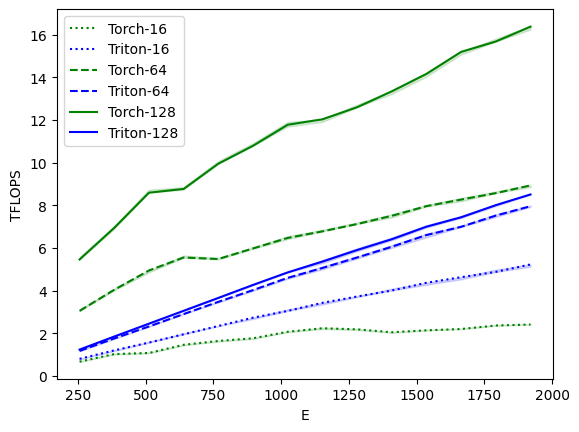

mlp-performance:
         E  Torch-16  Triton-16  Torch-64  Triton-64  Torch-128  Triton-128
0    256.0  0.668735   0.799220  3.048186   1.170286   5.461333    1.234708
1    384.0  1.024000   1.196549  4.040755   1.755429   6.948046    1.846084
2    512.0  1.074361   1.562706  4.946113   2.319858   8.594885    2.449944
3    640.0  1.457976   1.950476  5.553898   2.899823   8.771025    3.053957
4    768.0  1.638400   2.340571  5.482750   3.474023   9.954836    3.657823
5    896.0  1.764431   2.730667  5.979659   4.024140  10.794165    4.267461
6   1024.0  2.069217   3.048186  6.472691   4.599017  11.781753    4.854519
7   1152.0  2.234182   3.427964  6.779586   5.063546  12.037225    5.362036
8   1280.0  2.184533   3.723636  7.123478   5.553898  12.603077    5.904144
9   1408.0  2.048000   4.004978  7.509333   6.057950  13.349926    6.410635
10  1536.0  2.137043   4.369067  7.963868   6.608672  14.169946    7.000229
11  1664.0  2.198982   4.630261  8.271534   6.994093  15.200990    7.44

In [29]:
benchmark_bwd1.run(show_plots=True, print_data=True)

In [15]:
@triton.autotune(
    configs=[
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 64}, num_stages=3, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 64}, num_stages=3, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 64, 'GROUP_SIZE_B': 1}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 128, 'GROUP_SIZE_B': 1}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 128}, num_stages=2, num_warps=4),
    ],
    key=['B', 'D', 'E'],
)
@triton.jit
def mlp_wide_kernel_bwd2(
    x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
    B, D: tl.constexpr, E,
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    stride_dxb, stride_dxd,
    stride_dw1d, stride_dw1e,
    stride_dw2e, stride_dw2d,
    stride_dob, stride_dod,
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr
):
    """Kernel for computing the mlp
    Z = X @ W1, H = f(Z), O = H @ W2
    - X has shape (B, D)
    - W1 has shape (D, E)
    - W2 has shape (E, D)
    - O has shape (B, D)
    - dX has shape (B, D)
    - dW1 has shape (D, E)
    - dW2 has shape (E, D)
    - dO has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    pid_b = tl.program_id(axis=0)
    # batch_groups = tl.cdiv(B, BLOCK_SIZE_B)
    # pid_b = pid % batch_groups
    # pid_h = pid // batch_groups
    # tl.device_print('pid_H', pid_h)
    # tl.device_print('pid_B', pid_b)
    # pid_d = tl.program_id(axis=1)
    TARGET_TYPE = x_ptr.type.element_ty

    offs_d = tl.arange(0, D)
    offs_e = tl.arange(0, BLOCK_SIZE_E)
    dw1_ptrs = dw1_ptr + (offs_d[:, None] * stride_dw1d + offs_e[None, :] * stride_dw1e)
    dw2_ptrs = dw2_ptr + (offs_e[:, None] * stride_dw2e + offs_d[None, :] * stride_dw2d)

    x_ptrs = tl.make_block_ptr(
        base=x_ptr,
        shape=(B, D),
        strides=(stride_xb, stride_xd),
        offsets=(pid_b * BLOCK_SIZE_B, 0),
        block_shape=(BLOCK_SIZE_B, D),
        order=(1, 0),
    )
    dx_ptrs = tl.make_block_ptr(
        base=dx_ptr,
        shape=(B, D),
        strides=(stride_dxb, stride_dxd),
        offsets=(pid_b * BLOCK_SIZE_B, 0),
        block_shape=(BLOCK_SIZE_B, D),
        order=(1, 0),
    )
    w1_ptrs = tl.make_block_ptr(
        base=w1_ptr,
        shape=(D, E),
        strides=(stride_w1d, stride_w1e),
        offsets=(0, 0),
        block_shape=(D, BLOCK_SIZE_E),
        order=(1, 0),
    )
    w2_ptrs = tl.make_block_ptr(
        base=w2_ptr,
        shape=(E, D),
        strides=(stride_w2e, stride_w2d),
        offsets=(0, 0),
        block_shape=(BLOCK_SIZE_E, D),
        order=(1, 0),
    )
    do_ptrs = tl.make_block_ptr(
        base=do_ptr,
        shape=(B, D),
        strides=(stride_dob, stride_dod),
        offsets=(pid_b * BLOCK_SIZE_B, 0),
        block_shape=(BLOCK_SIZE_B, D),
        order=(1, 0),
    )
    x = tl.load(x_ptrs) # BLOCK_SIZE_B, D
    do = tl.load(do_ptrs) # BLOCK_SIZE_B, D
    dx = tl.zeros((BLOCK_SIZE_B, D), dtype=tl.float32)  # BLOCK_SIZE_B, D
    for e in range(0, tl.cdiv(E, BLOCK_SIZE_E)):

        w1 = tl.load(w1_ptrs) # D, BLOCK_SIZE_E
        w2 = tl.load(w2_ptrs) # BLOCK_SIZE_E, D

        z = tl.dot(x, w1, out_dtype=tl.float32)                         # BLOCK_SIZE_B, BLOCK_SIZE_E
        # activation
        if ACTIVATION == "leaky_relu":
            h = leaky_relu(z).to(TARGET_TYPE)                           # BLOCK_SIZE_B, BLOCK_SIZE_E
        else:
            h = z.to(TARGET_TYPE)                                       # BLOCK_SIZE_B, BLOCK_SIZE_E

        dw2 = tl.dot(tl.trans(h), do, out_dtype=tl.float32)             # BLOCK_SIZE_E, D
        dh = tl.dot(do, tl.trans(w2), out_dtype=tl.float32)             # BLOCK_SIZE_B, BLOCK_SIZE_E

        if ACTIVATION == "leaky_relu":
            dz = (dh * d_leacky_relu_inv_backward(z)).to(TARGET_TYPE)   # BLOCK_SIZE_B, BLOCK_SIZE_E
        else:
            dz = dh.to(TARGET_TYPE)

        dw1 = tl.dot(tl.trans(x), dz, out_dtype=tl.float32)             # D, BLOCK_SIZE_E
        dx = tl.dot(dz, tl.trans(w1), dx, out_dtype=tl.float32)         # BLOCK_SIZE_B, D

        dw1 = dw1.to(TARGET_TYPE)
        dw2 = dw2.to(TARGET_TYPE)

        tl.atomic_add(dw1_ptrs, dw1)
        tl.atomic_add(dw2_ptrs, dw2)
        """
        """

        dw1_ptrs += BLOCK_SIZE_E * stride_dw1e
        dw2_ptrs += BLOCK_SIZE_E * stride_dw2e
        w1_ptrs = tl.advance(w1_ptrs, (0, BLOCK_SIZE_E))
        w2_ptrs = tl.advance(w2_ptrs, (BLOCK_SIZE_E, 0))


    dx = dx.to(TARGET_TYPE)
    tl.store(dx_ptrs, dx)

    """
    """


In [16]:
def mlp_wide_triton_bwd2(x, w1, w2, o, do, activation=""):
    # Check constraints.
    assert x.shape[1] == w1.shape[0], "Incompatible dimensions"
    assert w1.shape[1] == w2.shape[0], "Incompatible dimensions"
    assert x.shape[1] == w2.shape[1], "Incompatible dimensions"
    assert x.shape[0] == o.shape[0], "Incompatible dimensions"
    assert x.shape[0] == do.shape[0], "Incompatible dimensions"
    assert o.shape[0] == do.shape[0], "Incompatible dimensions"
    assert o.shape[1] == do.shape[1], "Incompatible dimensions"
    assert x.is_contiguous(), "Matrix X must be contiguous"
    assert w1.is_contiguous(), "Matrix W1 must be contiguous"
    assert w2.is_contiguous(), "Matrix W2 must be contiguous"
    assert o.is_contiguous(), "Matrix O must be contiguous"
    assert do.is_contiguous(), "Matrix dO must be contiguous"

    B, D = x.shape
    E = w1.shape[-1]

    # Allocates output.
    dx = torch.zeros_like(x)
    dw1 = torch.zeros_like(w1)
    dw2 = torch.zeros_like(w2)
    # print(dx.shape, dw1.shape, dw2.shape, do.shape)

    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        triton.cdiv(B, META['BLOCK_SIZE_B']),
    )
    mlp_wide_kernel_bwd2[grid](
        x, w1, w2, o, dx, dw1, dw2, do,
        B, D, E,
        x.stride(0), x.stride(1),
        w1.stride(0), w1.stride(1),
        w2.stride(0), w2.stride(1),
        o.stride(0), o.stride(1),
        dx.stride(0), dx.stride(1),
        dw1.stride(0), dw1.stride(1),
        dw2.stride(0), dw2.stride(1),
        do.stride(0), do.stride(1),
        ACTIVATION=activation
    )

    # print(dx.shape, dw1.shape, dw2.shape)
    return dx, dw1, dw2


In [17]:
def unit_test_bwd2():
    # torch.manual_seed(19)
    DTYPE = torch.float32
    B = 1
    D = 16
    E = 32
    H = 1
    x = torch.randn((B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    w1 = torch.randn((D, E), device='cuda', dtype=DTYPE) / np.sqrt(E)
    w2 = torch.randn((E, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    o = torch.randn((B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    do = torch.randn((B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    triton_output = mlp_wide_triton_bwd2(x, w1, w2, o, do, activation="")
    torch_output = mlp_torch_bwd(x, w1, w2, o, do, activation="")
    print(f"triton_output={triton_output[0].shape, triton_output[0]}")
    print(f"torch_output={torch_output[0].shape, torch_output[0]}")
    if torch.allclose(triton_output[0], torch_output[0], atol=5e-2, rtol=5e-2):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

    dx_diff = np.abs(triton_output[0].to(torch.float32).cpu().numpy() - torch_output[0].to(torch.float32).cpu().numpy())
    print("dx max diff:",np.max(dx_diff), "mean diff:",np.mean(dx_diff))

    dw1_diff = np.abs(triton_output[1].to(torch.float32).cpu().numpy() - torch_output[1].to(torch.float32).cpu().numpy())
    print("dw1 max diff:",np.max(dw1_diff), "mean diff:",np.mean(dw1_diff))
    
    dw2_diff = np.abs(triton_output[2].to(torch.float32).cpu().numpy() - torch_output[2].to(torch.float32).cpu().numpy())
    print("dw2 max diff:", np.max(dw2_diff), "mean diff:", np.mean(dw2_diff))

unit_test_bwd2()


triton_output=(torch.Size([1, 16]), tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       device='cuda:0'))
torch_output=(torch.Size([1, 16]), tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       device='cuda:0'))
❌ Triton and Torch differ
dx max diff: nan mean diff: nan
dw1 max diff: nan mean diff: nan
dw2 max diff: nan mean diff: nan


In [18]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['E'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            # 2 ** i for i in range(5, 12)
            128 * i for i in range(2, 16)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch-16', 'triton-16', 'torch-64', 'triton-64', 'torch-128', 'triton-128'],
        # Label name for the lines
        line_names=["Torch-16", "Triton-16", "Torch-64", "Triton-64", "Torch-128", "Triton-128"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark_bwd2(E, provider):
    dtype = torch.float16
    D = int(provider[provider.find('-') + 1:])
    HEAD = 768 // D
    L = 1024
    S = 1
    B = L * S
    x = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)
    w1 = torch.randn((D, E), device='cuda', dtype=dtype) / np.sqrt(E)
    w2 = torch.randn((E, D), device='cuda', dtype=dtype) / np.sqrt(D)
    o = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)
    do = torch.randn((B, D), device='cuda', dtype=dtype) / np.sqrt(D)

    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('torch'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_torch_bwd(x, w1, w2, o, do, activation="leaky_relu"), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_wide_triton_bwd2(x, w1, w2, o, do, activation="leaky_relu"), quantiles=quantiles)
    perf = lambda ms: 8 * B * D * E * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


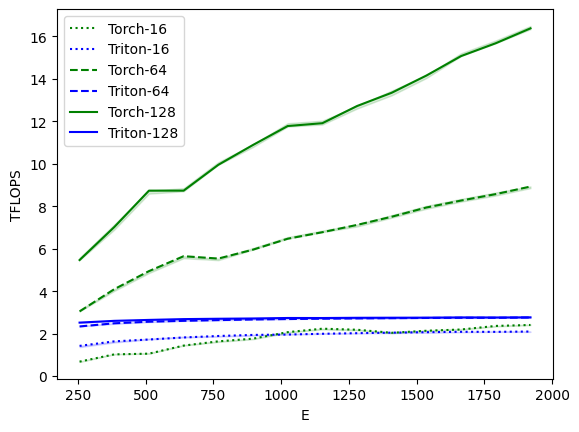

mlp-performance:
         E  Torch-16  Triton-16  Torch-64  Triton-64  Torch-128  Triton-128
0    256.0  0.682667   1.424696  3.048186   2.340571   5.468454    2.520615
1    384.0  1.024000   1.637547  4.096000   2.488709   7.021714    2.604079
2    512.0  1.058099   1.724632  4.946113   2.562972   8.738134    2.647919
3    640.0  1.437981   1.820444  5.649655   2.604511   8.738133    2.685902
4    768.0  1.638400   1.890462  5.538253   2.639034   9.954836    2.702515
5    896.0  1.764431   1.940781  5.957818   2.667163  10.890255    2.715513
6   1024.0  2.071261   1.958582  6.472691   2.688656  11.781753    2.738690
7   1152.0  2.234182   1.994333  6.779586   2.705615  11.915637    2.737002
8   1280.0  2.184533   2.022716  7.123478   2.719336  12.725437    2.747841
9   1408.0  2.041475   2.048000  7.509333   2.730667  13.349926    2.751512
10  1536.0  2.137043   2.069558  7.943758   2.740181  14.161972    2.754578
11  1664.0  2.195794   2.088157  8.271534   2.748284  15.079079    2.76

In [19]:
benchmark_bwd2.run(show_plots=True, print_data=True)
